## Deep Learning

### Assignment 5

The goal of this assignment is to train a Word2Vec skip-gram model over Text8 data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.

from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
%matplotlib inline

In [3]:
url = 'http://mattmahoney.net/dc/'
data_path = '/Users/heany/code/AI-For-NLP/dataset'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(os.path.join(data_path, filename)):
        filename, _ = urlretrieve(url + filename, os.path.join(data_path, filename))
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

FileNotFoundError: [Errno 2] No such file or directory: 'text8.zip'

In [4]:
filename = os.path.join(data_path,'text8.zip')

Read the data into a string.


In [5]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Data size {}'.format(len(words)))

Data size 17005207


In [6]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [7]:
collections.Counter(words).most_common(10)

[('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430),
 ('two', 192644)]

In [8]:
collections.deque(maxlen=2)

deque([])

Build the dictionary and replace rare words with UNK token.

In [6]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK',-1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0 # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
#     id2word = {v:k for k,v in dictionary.items()}
    return data, count, dictionary, reverse_dictionary 
    
data, count, dictionary, reverse_dictionary = build_dataset(words)
print("Most common words (+UNK):{}".format(count[:5]))
print("Sample data", data[:10])
del words # Hint to reduce memory

Most common words (+UNK):[['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [7]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert num_skips % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'anarchism', 'originated', 'a', 'of', 'as', 'term', 'originated']


In [11]:
batch.shape

(8,)

In [12]:
labels.shape

(8, 1)

In [13]:
batch

array([12, 12, 12, 12,  6,  6,  6,  6], dtype=int32)

In [14]:
labels

array([[3081],
       [5234],
       [   6],
       [ 195],
       [   2],
       [3081],
       [  12],
       [ 195]], dtype=int32)

Train a skip-gram model.


In [9]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model.
    # Look up embedding for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time
    '''
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(
            weights = softmax_weights, 
            biases = softmax_biases, 
            inputs = embed, 
            labels = train_labels, 
            num_sampled = num_sampled, 
            num_classes = vocabulary_size)
    )
    '''
    # Compute the NCE loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights = softmax_weights, 
            biases = softmax_biases, 
            inputs = embed, 
            labels = train_labels, 
            num_sampled = num_sampled, 
            num_classes = vocabulary_size)
    )
    
    # We use the SGD optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(loss)
    
    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    # optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Compute the similarity between miibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))



num_steps = 100001
loss_skip_gram = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized!!")
    
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, num_skips, skip_window
        )
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            loss_skip_gram.append(average_loss)
            average_loss = 0
        # Note that this is expensive (-20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to {}:'.format(valid_word)
                for k in range(top_k):
                      close_word = reverse_dictionary[nearest[k]]
                      log = '{} {},'.format(log, close_word)
                print(log)

    final_embeddings = normalized_embeddings.eval()

Initialized!!
Average loss at step 0: 275.335449
Nearest to see: kw, yttrium, warez, precautions, netted, reston, bakker, hbk,
Nearest to time: falsetto, algebraic, sour, slits, sun, presently, sulfuric, minimax,
Nearest to a: inspirational, stanis, pauli, toughest, gob, demolish, radiated, kyi,
Nearest to b: leclerc, buffer, boyle, terrains, hotels, lucasarts, tenniel, celtics,
Nearest to seven: distressing, lattices, chordal, einen, esau, alloy, distinctively, koan,
Nearest to can: reforestation, debasement, hjalmar, soybeans, protectorates, contractors, reads, ritually,
Nearest to known: murray, lovable, nite, substituted, headache, edison, hydrology, centum,
Nearest to system: wuxia, moves, delirium, pregnant, tc, broome, happiness, susanna,
Nearest to not: sukhoi, seditious, glitter, alton, decolonization, kalmar, combinatorial, pernoud,
Nearest to s: shortage, adopted, byproduct, homeopathic, intervarsity, gear, hbar, petitioning,
Nearest to three: prelate, maharashtri, concoctio

Average loss at step 52000: 5.216136
Average loss at step 54000: 5.058130
Average loss at step 56000: 5.095540
Average loss at step 58000: 4.857321
Average loss at step 60000: 4.907200
Nearest to see: kw, eindhoven, albania, dione, salamander, precautions, checksum, analogy,
Nearest to time: benzyl, stadtbahn, phonetic, sc, tail, rho, neutronic, traitors,
Nearest to a: the, widehat, grue, no, edmonton, wff, zal, nicobar,
Nearest to b: d, boyle, arctocephalus, UNK, sepp, mistakes, hemionus, gris,
Nearest to seven: six, eight, four, five, nine, three, zero, two,
Nearest to can: would, could, will, may, should, might, must, cannot,
Nearest to known: used, parl, murray, headache, toys, publicacion, promotion, lactantius,
Nearest to system: broome, galesburg, stadtbahn, dione, jed, imine, hol, crescent,
Nearest to not: it, you, also, still, panama, they, be, nba,
Nearest to s: and, zero, of, ur, mg, his, dop, six,
Nearest to three: four, five, six, seven, two, eight, one, stadtbahn,
Nearest

In [86]:
final_embeddings.shape

(50000, 128)

In [87]:
(np.min(final_embeddings),np.max(final_embeddings))

(-0.67082024, 0.54890996)

In [88]:
num_points = 400
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter =5000,method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1,:])

In [89]:
two_d_embeddings.shape

(400, 2)

In [90]:
two_d_embeddings.shape

(400, 2)

In [91]:
(np.min(two_d_embeddings), np.max(two_d_embeddings))

(-65.96459, 73.79557)

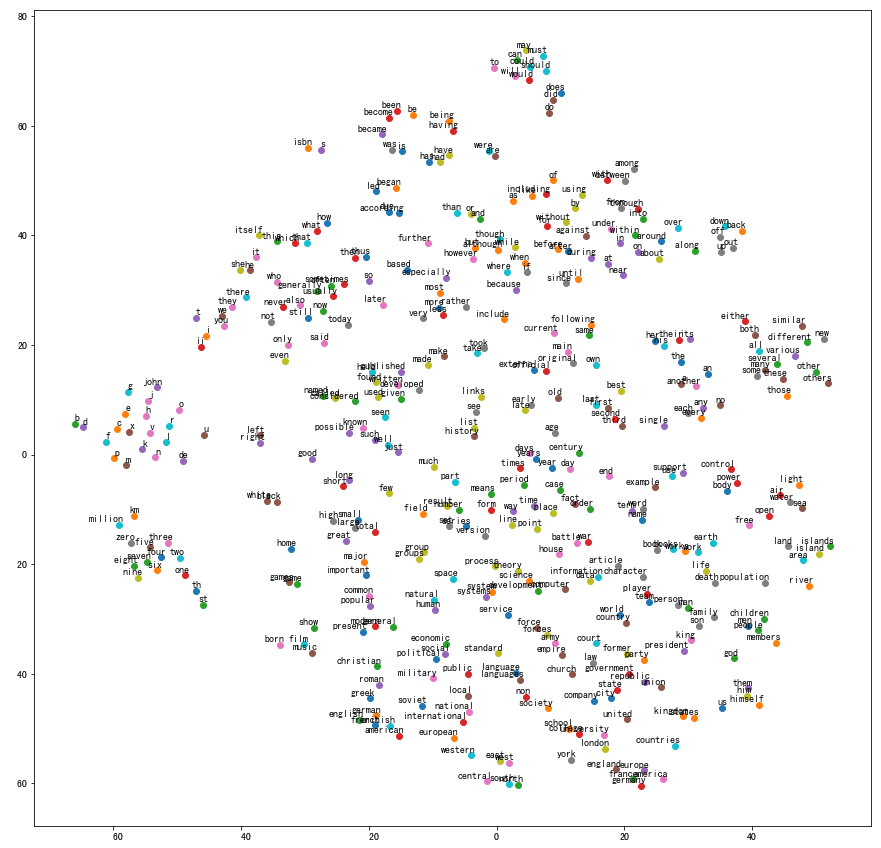

In [92]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

### Problem

An alternative to skip-gram is another Word2Vec model called CBOW (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.



In [93]:
reverse_dictionary[2]

'of'

In [94]:
data_index = 0

def generate_batch_cbow(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    context_window = 2 * skip_window
    assert batch_size % context_window == 0
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = context_window + 1
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span-1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[target]
            labels[i * num_skips + j, 0] = buffer[skip_window]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # merge labels
    # subsample every `context_window` elements
    labels_merged = labels[::context_window]
  
    return batch, labels_merged

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=16, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(int(16/(2*skip_window)))])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'of', 'a', 'abuse', 'term', 'first', 'of', 'used', 'abuse', 'first', 'against']
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 4 and skip_window = 2:
    batch: ['anarchism', 'a', 'originated', 'term', 'term', 'originated', 'of', 'as', 'of', 'abuse', 'a', 'as', 'a', 'term', 'abuse', 'first']
    labels: ['as', 'a', 'term', 'of']


In [95]:
batch

array([5234,    6, 3081,  195,  195, 3081,    2,   12,    2, 3134,    6,
         12,    6,  195, 3134,   46], dtype=int32)

In [96]:
labels

array([[ 12],
       [  6],
       [195],
       [  2]], dtype=int32)

In [98]:
tf.nn.embedding_lookup?

In [114]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
context_window = 2 * skip_window
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size / context_window, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # sum every `context_window` word embedding into one
    segment_ids = tf.constant([i / context_window for i in range(batch_size)])
    segment_ids = tf.cast(segment_ids, tf.int32)
    embed = tf.segment_sum(embed, segment_ids)
  
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(
            weights=softmax_weights, 
            biases=softmax_biases, 
            inputs=embed,
            labels=train_labels, 
            num_sampled=num_sampled, 
            num_classes=vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

    
num_steps = 100001

loss_cbow = []


with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch_cbow(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        # _, l = tdb.debug([optimizer, loss], feed_dict=feed_dict, session=session)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            loss_cbow.append(average_loss)
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 50000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.617788
Nearest to or: goal, gymnast, blaze, jammu, physician, continued, meridians, ruth,
Nearest to into: victims, mycology, conditioners, hyperactivity, telepathy, anchorage, needing, einsatzgruppen,
Nearest to is: mirabilis, jeet, pompous, cycled, imaginable, avid, vuoksi, diamondbacks,
Nearest to people: voluminous, lemmings, respected, unmodified, plosives, mephisto, acr, sqrt,
Nearest to th: lucy, floppies, maecenas, stds, trolling, cached, ephemerides, intravenous,
Nearest to eight: damages, calvinist, evangelica, asahi, kindling, hillbilly, cabo, shortage,
Nearest to states: marcello, carina, kaolinite, montevideo, unarable, seminal, qualification, perceptive,
Nearest to of: peloponnesian, entebbe, juggernaut, outpost, ttingen, hypothesis, georg, monday,
Nearest to will: unattested, magnesium, scarce, loaf, mond, scribe, curiously, frieze,
Nearest to as: demokratische, northeastern, recognise, indecisive, straightforward, brewery, glycoprot

In [111]:
print(len(loss_cbow))

51


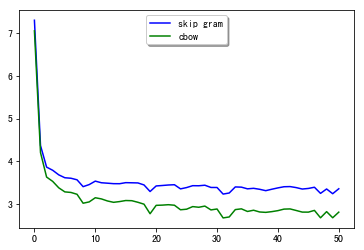

In [112]:

# loss_cbow 
# loss_skip_gram
import matplotlib.pyplot as plt

steps = np.arange(len(loss_cbow))
fig, ax = plt.subplots()

ax.plot(steps, loss_skip_gram, 'b', label="skip gram")
ax.plot(steps, loss_cbow, 'g', label="cbow")

# Now add the legend with some customizations.
legend = ax.legend(loc='upper center', shadow=True)

plt.show()

In [130]:
import math
from collections import Counter

def myres(alist):    
    a = [t[0] for t in alist]
    b = [t[1] for t in alist]
    numa = len(set(a))
    numb = len(set(b))
    
    flag = True
    
    target = [(k,v) for k in set(a) for v in set(b) if (k,v) in alist]
    for m,n in alist:
        if m not in [r[0] for r in target] and n not in [rr[0] for rr in target]:
            flag = False
            break
    
    if flag: 
        print("{} {}".format(target[0][0], target[0][1]))
    else:
        print("No")
        
n = int(input().strip())
A = list()
for _ in range(n):
    t = input().strip().split()
    A.append((t[0],t[1]))
myres(A)

4
1
5
3
5
1
3
5
5
1 3


In [124]:
a = [1,2,3,3,4,5,6]
aa = [2,3,5,4,6,7]

b = [k  for k in a for v in aa if k==v]

In [125]:
b

[2, 3, 3, 4, 5, 6]